In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 1. Identifying Valid Participants, Converting Raw Filenames to Correct Naming Formats

In [131]:
# Packages
import os
import shutil
from pathlib import Path
from typing import Iterable, List, Tuple, Dict
import importlib

# Custom Components
from components import file_handling as fh
from components import separate
import classes as c

# Reload components
importlib.reload(fh)
importlib.reload(separate)
importlib.reload(c)

_RAWS_DIR = os.path.join('.', 'samples', 'raws')
_ROOT_DIR = os.path.join('.', 'samples', 'processed')
_EXPECTED_FILES = [
#   'calibration_test.csv',     # <-- Early participants won't have this one
    'calibration_test_1.csv',
    'calibration_test_2.csv',
    'calibration_test_3.csv',
    'calibration_test_4.csv',
    'calibration_test_5.csv',
    'calibration_test_6.csv',
    'calibration_test_7.csv',
    'eye.csv',
    'eeg-rest.csv',
    'eeg-vr.csv',
    'pedestrians.csv'
]
_FILENAME_REMAP = {
    'calibration_test.csv':     'calibration_0.csv',
    'calibration_test_1.csv':   'calibration_1.csv',
    'calibration_test_2.csv':   'calibration_2.csv',
    'calibration_test_3.csv':   'calibration_3.csv',
    'calibration_test_4.csv':   'calibration_4.csv',
    'calibration_test_5.csv':   'calibration_5.csv',
    'calibration_test_6.csv':   'calibration_6.csv',
    'calibration_test_7.csv':   'calibration_7.csv',
    'eye.csv':                  'eye.csv',
    'eeg-rest.csv':             'eeg_rest.csv',
    'eeg-vr.csv':               'eeg_vr.csv',
    'pedestrians.csv':          'pedestrians.csv'
}

# Identify valid and invalid participant directories
present, missing = separate.identify_valid_participants(_RAWS_DIR, _EXPECTED_FILES)
print("Present:")
for p in present: print(f'\t{p}')
print("Missing:")
for p in missing: print(f'\t{p}')

# Copy and Paste valid participants
pdirs = separate.copy_and_rename(present, _FILENAME_REMAP, _ROOT_DIR)
print("New Source Files:")
for p in pdirs: print(f'\t{p}')


Present:
	samples\raws\P1
	samples\raws\P10
	samples\raws\P13
	samples\raws\P2
	samples\raws\P3
	samples\raws\P4_Mus2
	samples\raws\P5
	samples\raws\P6
	samples\raws\P7
	samples\raws\P8
	samples\raws\P9
	samples\raws\PI1
	samples\raws\PI2
Missing:
	('samples\\raws\\P0', 10, ['calibration_test_1.csv', 'calibration_test_2.csv', 'calibration_test_3.csv', 'calibration_test_4.csv', 'calibration_test_5.csv', 'calibration_test_6.csv', 'calibration_test_7.csv', 'eeg-vr.csv', 'eye.csv', 'pedestrians.csv'])
New Source Files:
	samples\processed\P1
	samples\processed\P10
	samples\processed\P13
	samples\processed\P2
	samples\processed\P3
	samples\processed\P4_Mus2
	samples\processed\P5
	samples\processed\P6
	samples\processed\P7
	samples\processed\P8
	samples\processed\P9
	samples\processed\PI1
	samples\processed\PI2


PI2:  92%|█████████▏| 12/13 [00:00<00:00, 12.27it/s]   

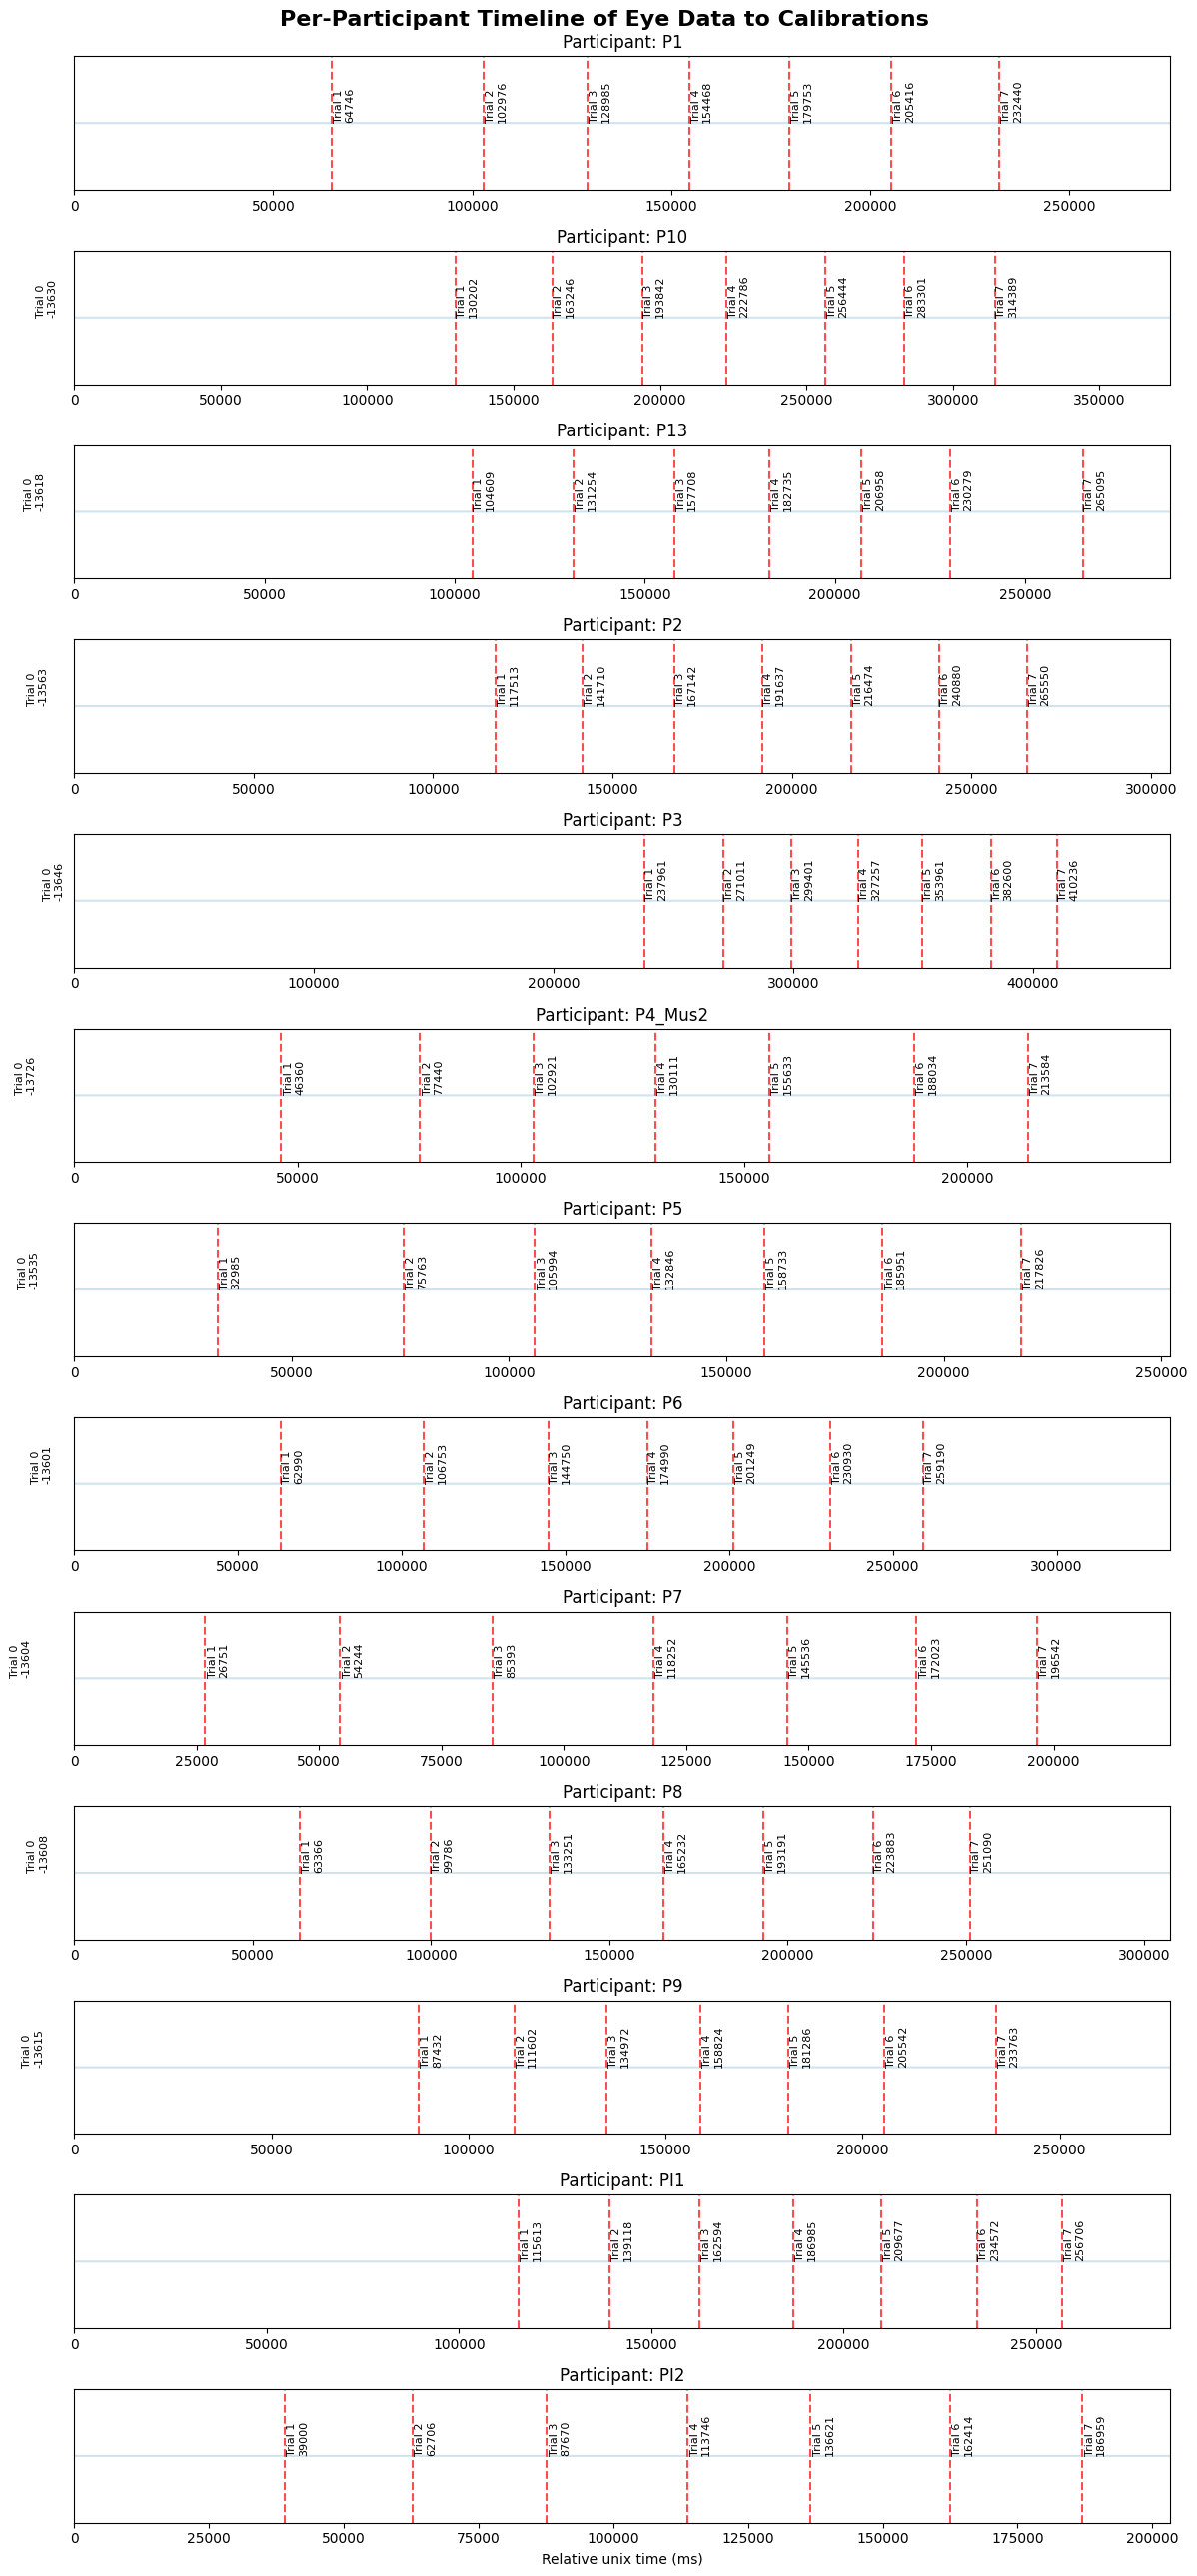

PI2: 100%|██████████| 13/13 [00:03<00:00,  4.18it/s]


In [257]:
importlib.reload(c)
c.plot_calibration_timeline(pdirs, outpath=os.path.join(_ROOT_DIR, 'calibration_timeline.png'))

In [267]:
importlib.reload(c)

experiment = c.Experiment(
    _ROOT_DIR, 
    pdirs, 
    verbose=False )          # Define experiment

P2:  23%|██▎       | 3/13 [00:05<00:19,  1.98s/it] 

PI2: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]   


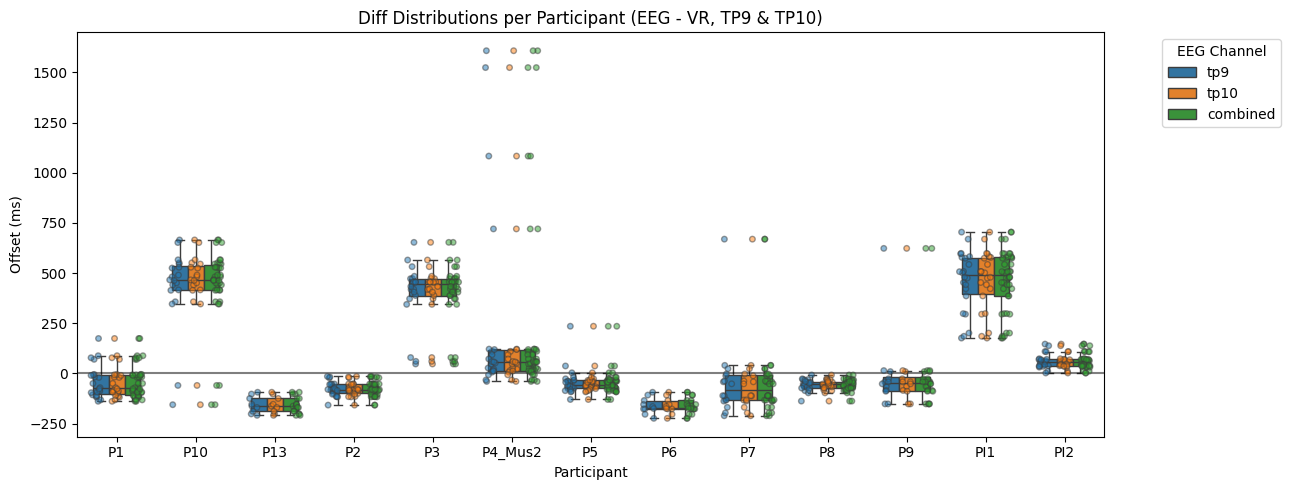

In [ ]:
importlib.reload(c)

# Plot offsets
c.plot_offsets(experiment.participants, 
                plot_type='box', 
                hue_feature='channel',
                outpath=os.path.join(experiment.root_dir,'blink_offsets.png'))

# Re-sort the rows in accordance to `_ACTIVE_PARTICIPANTS`


In [54]:
importlib.reload(separate)

_TRIAL_NAMES = [
    "Activation",
    "Trial-ApproachAudio Start", 
    "Trial-BehindAudio Start", 
    "Trial-Behind Start", 
    "Trial-AlleyRunnerAudio Start", 
    "Trial-AlleyRunner Start", 
    "Trial-Approach Start"
]

for pdir in pdirs: 
    print(separate.identify_calibration_order(pdir))

[{'unix_ms': 1758829675519, 'rel_timestamp': 112.6499, 'frame': 5737, 'event': 'Calibration'}, {'unix_ms': 1758829700506, 'rel_timestamp': 137.6232, 'frame': 6767, 'event': 'Calibration'}, {'unix_ms': 1758829725291, 'rel_timestamp': 162.4232, 'frame': 7896, 'event': 'Calibration'}, {'unix_ms': 1758829750307, 'rel_timestamp': 187.4232, 'frame': 8807, 'event': 'Calibration'}, {'unix_ms': 1758829774728, 'rel_timestamp': 211.8499, 'frame': 9886, 'event': 'Calibration'}, {'unix_ms': 1758829799593, 'rel_timestamp': 236.7166, 'frame': 10830, 'event': 'Calibration'}, {'unix_ms': 1758829823510, 'rel_timestamp': 260.6232, 'frame': 11808, 'event': 'Calibration'}]
[{'unix_ms': 1759347760363, 'rel_timestamp': 233.6543, 'frame': 10079.0, 'event': 'Calibration'}, {'unix_ms': 1759347793763, 'rel_timestamp': 267.0543, 'frame': 11501.0, 'event': 'Calibration'}, {'unix_ms': 1759347821857, 'rel_timestamp': 295.161, 'frame': 12937.0, 'event': 'Calibration'}, {'unix_ms': 1759347849940, 'rel_timestamp': 323.

# 2. File Sorting into Trials

P6: 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]     


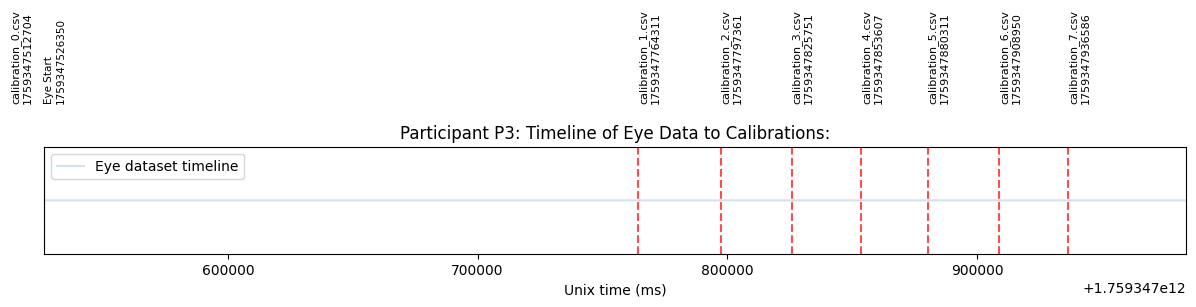

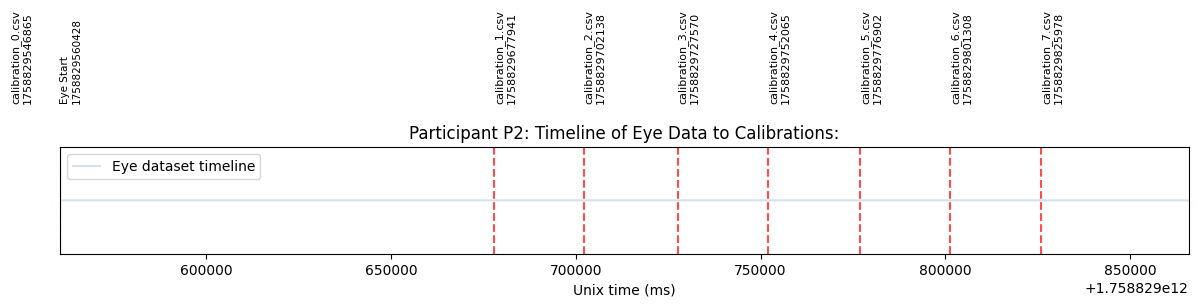

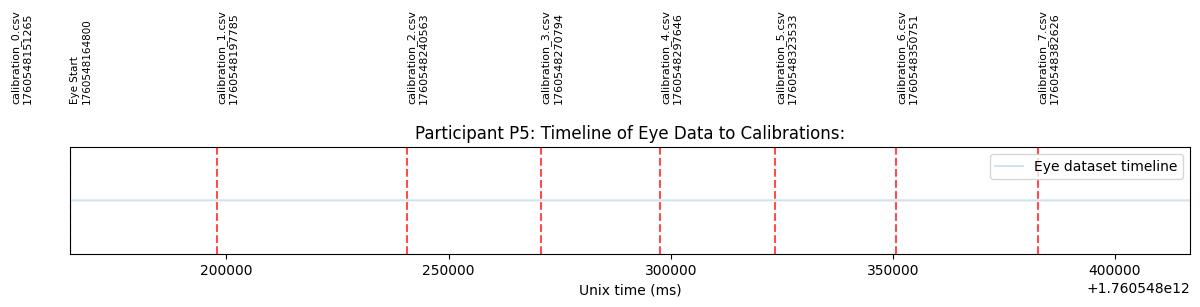

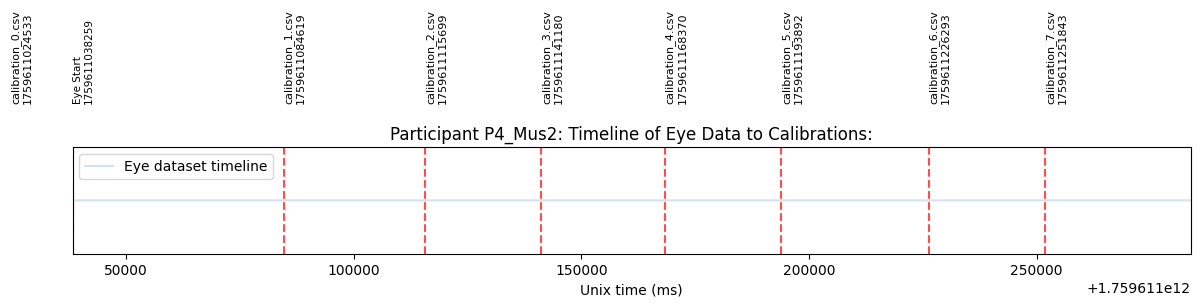

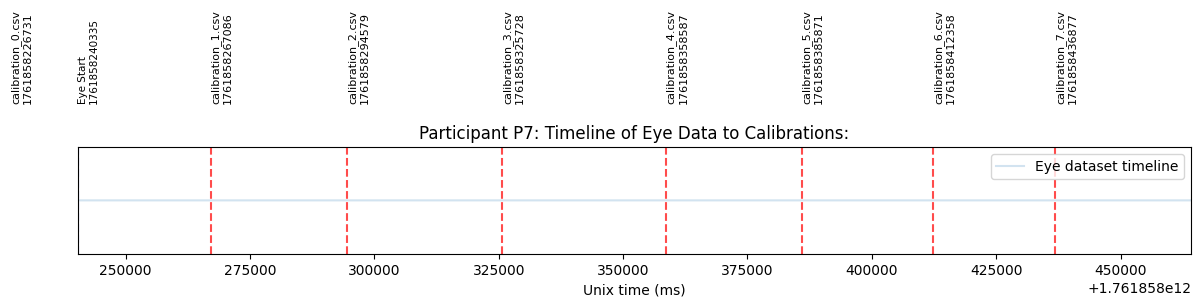

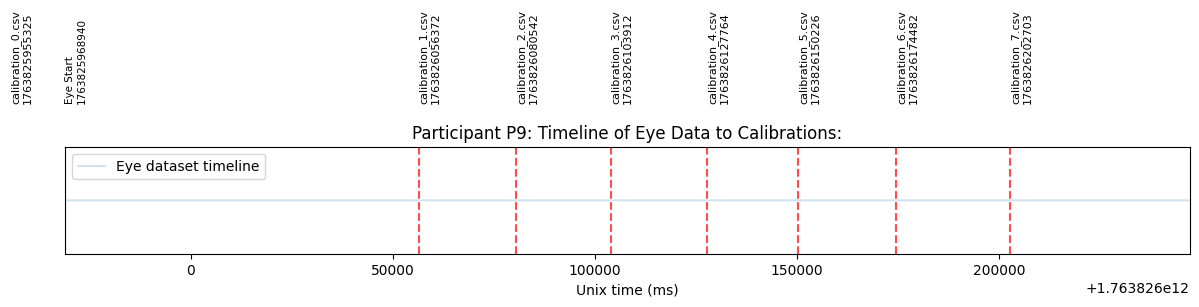

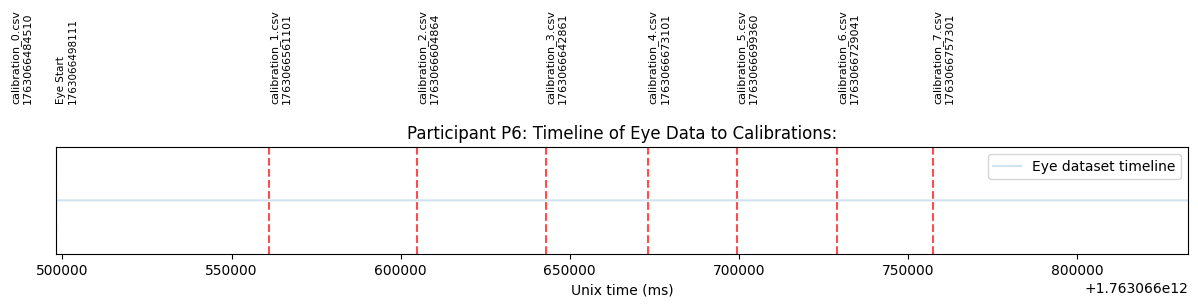

In [ ]:
import os
import pandas as pd
from tqdm import tqdm
pd.options.mode.chained_assignment = None  # default='warn'

from components import eeg_handling as eh, plot_handling as ph
importlib.reload(eh)
importlib.reload(ph)
_TRIAL_NAMES = [
    "Trial-ApproachAudio Start", 
    "Trial-BehindAudio Start", 
    "Trial-Behind Start", 
    "Trial-AlleyRunnerAudio Start", 
    "Trial-AlleyRunner Start", 
    "Trial-Approach Start"
]

_CALIBRATION_COLUMNS = [
    'unix_ms', 
    'frame', 
    'rel_timestamp',
    'event', 
    'overlap_counter'
]

# 
def read_calibration_file(_F:str, correction:bool=True):
    # Read the file
    df = pd.read_csv(_F)

    # Correction, if necessary
    if correction: 
        df = df.iloc[:, :len(_CALIBRATION_COLUMNS)]
        df.columns = _CALIBRATION_COLUMNS

# SEPARATE FILES INTO TRIALS
def separate_into_trials( pdirs: Iterable[str] ) -> None:
    # Iterate through eahch participant directory
    pbar = tqdm(pdirs)
    for pdir in pbar:
        # Initialize Path and pbar, update pbar
        ppath = Path(pdir)
        pid = os.path.basename(pdir)
        pbar.set_description(pid)
        # Create the outpuyt directory for the rest state
        output_dir = fh.mkdirs(os.path.join(pdir, 'rest/'))
        # Read the eeg_rest data 
        eeg, blinks = eh.read(os.path.join(pdir, 'eeg_rest.csv'))
        raw, processed = eh.separate(eeg)
        #  Save rest data
        raw.to_csv(os.path.join(output_dir, 'raw.csv'), index=False)
        processed.to_csv(os.path.join(output_dir, 'processed.csv'), index=False)
        blinks.to_csv(os.path.join(output_dir, 'muse_blinks.csv'), index=False)

        # Render Eye-To-Calibration Files
        calibration_files = [str(cal_file) for cal_file in sorted(ppath.glob("calibration_*.csv"))]
        eye_file = os.path.join(pdir, 'eye.csv')
        ph.eye_calibration_timeline(
            pid, 
            eye_file, 
            calibration_files, 
            show = False,
            outpath = os.path.join(pdir, 'eye_to_cal_timeline.png')
        )
        



separate_into_trials(pdirs)